# Nhập môn trí tuệ nhân tạo
## Thông tin
### Nhóm: 16
### Thành viên:
- Đào Nhật Minh - 20200392
- Hoàng Vân Trường - 20205134
- Nguyễn Thu Trang - 20205035
- Trần Anh Tuấn - 20205041
- Nguyễn Giang Nam - 20205103
### Giảng viên hướng dẫn:
- PGS. Trần Đình Khang
## Giới thiệu:
### Mục tiêu

### Mục lục
- [Các thực thể](#entity)
- [Đọc file dữ liệu](#readData)
- [Tìm đường gần nhất từ 1 điểm](#nearestRoad)
- [Hiển thị bản đồ](#displayMap)
- [Tìm đường](#findPath)


Chạy các lệnh sau nếu máy tính không có sẵn thư viện

In [1]:
#! python3.10 -m pip install numpy
#! python3.10 -m pip install matplotlib 
#! python3.10 -m pip install opencv-python

In [2]:
import json
import numpy as np
from queue import PriorityQueue
import codecs
import cv2
import matplotlib.pyplot as plt

<a name = "entity"/>

## 1. Các thực thể

In [3]:
class Street:
  def __init__(self, id, name):
    self.id = id
    self.name = name
    
class Point:
  def __init__(self, id, x, y, streetList: list):
    self.id = id
    self.x = x
    self.y = y
    self.streetList = streetList
  
  def getId(self) -> int:
    return self.id
  
  def getPosition(self) -> list:
    return [self.x, self.y]
  
  def getStreetList(self) -> list:
    return self.streetList

road_id = 0
class Road:
  def __init__(self , point1: Point, point2: Point, oneWayRoad):
    global road_id
    self.id = road_id
    road_id += 1
    self.point1 = point1
    self.point2 = point2
    self.oneWayRoad = oneWayRoad
  def getPoint1(self)->Point:
    return self.point1
  def getPoint2(self)->Point:
    return self.point2
  def getLength(self):
    if self.length != -1:
      x1, y1 = self.getPoint1().getPosition()
      x2, y2 = self.getPoint2().getPosition()
      self.length = ((x1-x2)**2+(y1-y2)**2)**(1/2)
    return abs()

class Graph:
  next_point_dict = {}
  def add_road(self, road_to_add: Road):
    p1Id = road_to_add.point1.getId()
    p2Id = road_to_add.point2.getId()
    if p1Id not in self.next_point_dict:
      self.next_point_dict[p1Id] = []
    if p2Id not in self.next_point_dict:
      self.next_point_dict[p2Id] = []
    if road_to_add.oneWayRoad!= 1:
      self.next_point_dict[p2Id] += [p1Id]
    if road_to_add.oneWayRoad!= -1:
      self.next_point_dict[p1Id] += [p2Id]
  def get_next_point_dict(self):
    return self.next_point_dict

<a name = "readData"/>

## 2. Đọc file dữ liệu

In [ ]:
scale_width_ratio = 0
scale_height_ratio = 0
x_max = 105.850260
y_max = 21.044922
x_min = 105.844521
y_min = 21.039959
streetDict = {}
pointDict = {}
roadDict = {}
graph = Graph()

In [5]:
def read_data_from_file():
    f = codecs.open("data.json", 'r', encoding='utf-8')
    fileContent = f.read()
    dataLoad = json.loads(fileContent)
    
    for street_id in dataLoad["street"]:
      newStreet = Street(street_id, dataLoad["street"][street_id])
      streetDict[street_id] = newStreet
    for point_id in dataLoad["point"]:
      tmpPoint = dataLoad["point"][point_id]
      newPoint = Point(int(point_id), tmpPoint["x"], tmpPoint["y"], tmpPoint["streetList"])
      pointDict[int(point_id)] = newPoint
    
    road_id = 0
    for road in dataLoad["road"]:
      newRoad = Road(pointDict[road["point1"]], pointDict[road["point2"]], road["oneWayRoad"])
      roadDict[road_id] = newRoad
      graph.add_road(newRoad)
      road_id = road_id + 1

read_data_from_file()

<a name = "nearestRoad"/>

## 3. Tìm đường gần nhất từ 1 điểm

In [7]:
def getNearestRoad(x, y):
    min_dis = np.inf
    nearest_line_index = -1
    nearest_point = [-1, -1]
    for i in range(len(roadDict)):
        
        distance , point = calculateDistance(x, y, roadDict[i])
        if distance < min_dis:
            nearest_line_index = i
            nearest_point = point
            min_dis = distance
    return roadDict[nearest_line_index], nearest_point

def calculateDistance(x, y, road: Road):
  x1,y1 = road.getPoint1().getPosition()
  x2,y2 = road.getPoint2().getPosition()

  u = [x2 - x1, y2 - y1]
  v = [x - x1, y - y1]
  proj_v_on_u = [(v[0]*u[0] + v[1]*u[1])/ (u[0]**2 + u[1]**2) * u[0], 
                   (v[0]*u[0] + v[1]*u[1])/ (u[0]**2 + u[1]**2) * u[1]]
  C = [x1 + proj_v_on_u[0], y1 + proj_v_on_u[1]]

  if (C[0] - x1)*(C[0] - x2) <= 0 and (C[1] - y1) * (C[1] - y2) <= 0:
    return np.sqrt((x - C[0])**2 + (y - C[1])**2), C
  else:
    dis_point1 = np.sqrt((x - x1)**2 + (y - y1)**2)
    dis_point2 = np.sqrt((x - x2)**2 + (y - y2)**2)

    if dis_point1 < dis_point2:
      return dis_point1, [x1, y1]
    else:
      return dis_point2, [x2, y2]


<a name = "displayMap"/>

## 4. Hiển thị bản đồ

In [ ]:
def pointTransform(position):
  x_temp, y_temp = position
  return [int((x_temp - x_min) * scale_width_ratio), 
          int((y_max - y_temp) * scale_height_ratio)]

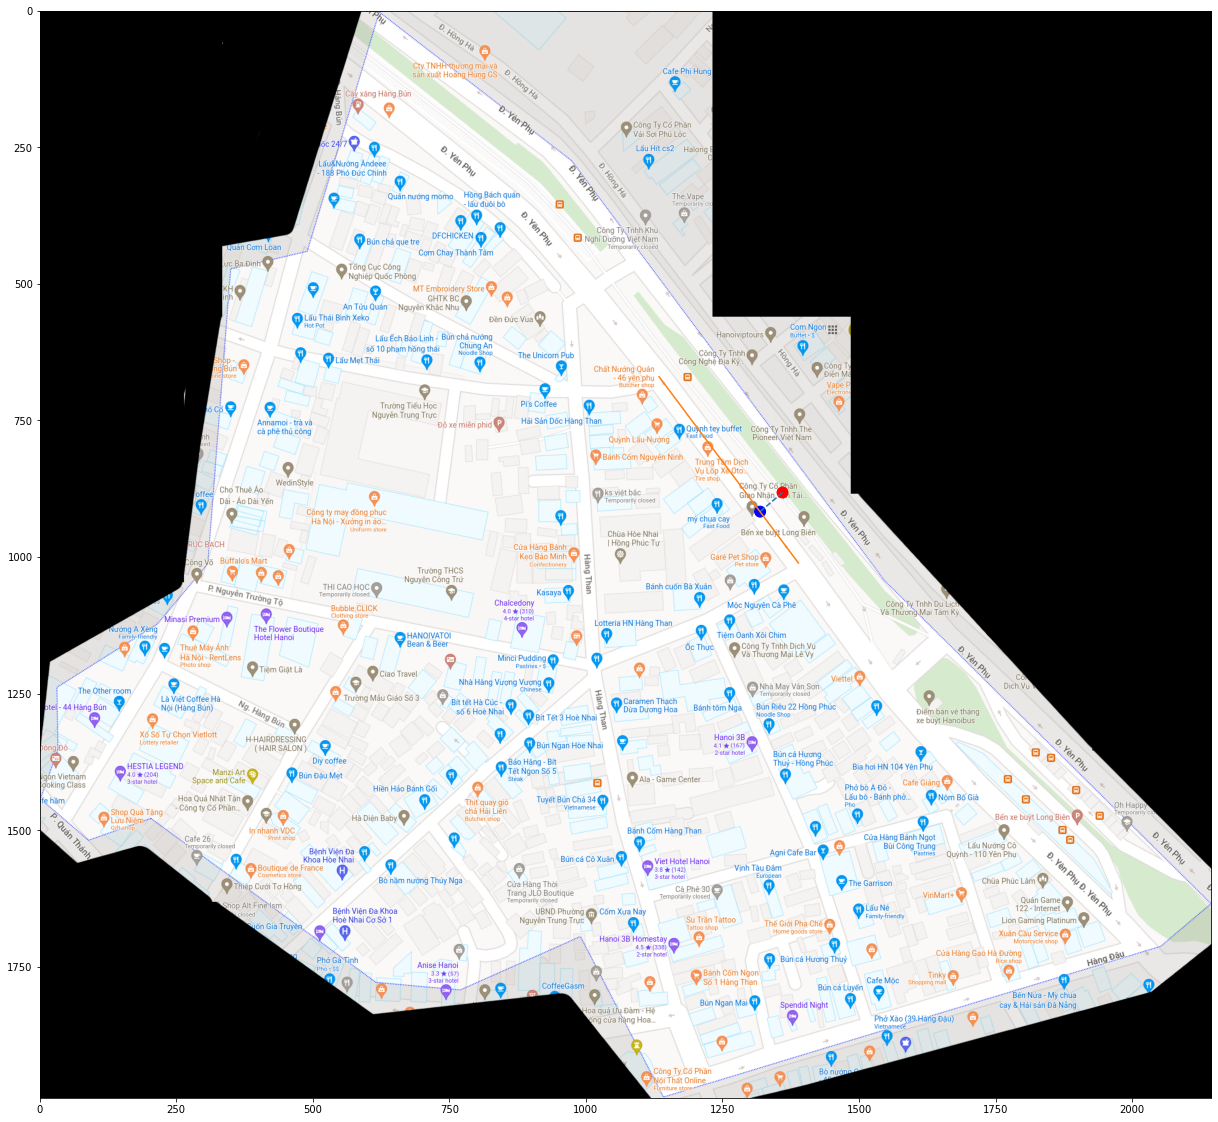

In [8]:

def read_image():
  global scale_width_ratio
  global scale_height_ratio
  fig, ax = plt.subplots(figsize=(21, 20))
  img = cv2.imread("./map.png")
  img_height, img_width, color_channel = img.shape
  ax.imshow(img)
  scale_width_ratio = img_width/(x_max-x_min)
  scale_height_ratio = img_height/(y_max-y_min)
  ax.set_xlim(0, img_width)
  ax.set_ylim(0, img_height)
  ax.invert_yaxis()

  # for pnt in pointDict:
  #   x_temp, y_temp = pointDict[pnt].getPosition()
  #   x_temp, y_temp = pointTransform([x_temp, y_temp])
  #   ax.add_patch(plt.Circle((x_temp,y_temp),5, color='r'))
  # nextP = graph.get_next_point_dict()
  # for pointId in nextP:
  #   p1x, p1y = pointTransform(pointDict[pointId].getPosition())
  #   point2 = nextP[pointId]
  #   for pt2Id in point2:
  #     p2x, p2y = pointTransform(pointDict[pt2Id].getPosition())
  #     ax.plot([p1x, p2x], [p1y, p2y])  

  x = 105.848160
  y = 21.042722
  nearestRoad, nearestPoint = getNearestRoad(x,y)
  
  x_temp, y_temp = pointTransform(Point(99,x,y,0).getPosition())
  ax.add_patch(plt.Circle((x_temp,y_temp),10, color='r'))
  
  p0x, p0y = pointTransform(Point(100,nearestPoint[0],nearestPoint[1],0).getPosition())
  ax.add_patch(plt.Circle((p0x,p0y),10, color='b'))
  ax.plot([x_temp, p0x], [y_temp, p0y], linestyle='--')

  p1x,p1y = pointTransform(nearestRoad.getPoint1().getPosition())
  p2x,p2y = pointTransform(nearestRoad.getPoint2().getPosition())
  ax.plot([p1x, p2x], [p1y, p2y]) 
  
  plt.show()
read_image()

<a name = "findPath"/>

## 5. Tìm đường

In [ ]:
def calculateLength(point1: Point, point2: Point):
  x1, y1 = point1.getPosition()
  x2, y2 = point2.getPosition()
  return ((x1-x2)**2+(y1-y2)**2)**(1/2)

In [9]:
def findPath(x_start, y_start, x_target, y_target):
  startRoad = getNearestRoad(x_start, y_start)
  targetRoad = getNearestRoad(x_target, y_target)
  visitedPoint = {}
  nextPointDict = graph.get_next_point_dict()
  pathPriorityQueue = PriorityQueue()
  pathPriorityQueue.put(
    ( calculateLength(startRoad.getPoint1(), 
                    Point(-1, x_start, y_start, [])),
      startRoad.getPoint1().getId()))
  pathPriorityQueue.put(
    ( calculateLength(startRoad.getPoint2(), 
                    Point(-1, x_start, y_start, [])),
      startRoad.getPoint2().getId()))
  while not pathPriorityQueue.empty():
    tempLength, tempPointId = pathPriorityQueue.get()
    if visitedPoint[tempPointId] == True:
      continue
    visitedPoint[tempPointId] = True
    for nextPointId in nextPointDict[tempPointId]:
      pathPriorityQueue.put(
        tempLength + calculateLength(
            pointDict[tempPointId], 
            pointDict[nextPointId]
          ),
        startRoad.getPoint2().getId()
      )
